In [1]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#Setting Scanpy figure parameters 
sc.settings.set_figure_params(dpi = 500, color_map = 'RdPu', dpi_save = 500)

In [4]:
adata_allcells = sc.read_h5ad("./adata_Final_for_Reinfection_publication.h5ad")
adata_allcells

AnnData object with n_obs × n_vars = 88360 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata = sc.AnnData(adata_allcells.raw.X, obs=adata_allcells.obs, var=adata_allcells.raw.var, uns=adata_allcells.uns)
adata = adata[adata.obs['leiden_lab_orig'].isin(['B cells',"Plasma cells"]), :]
adata

View of AnnData object with n_obs × n_vars = 4570 × 26030
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [6]:
adata.raw = adata.copy()
# keep blacklist genes from vars (they are stored in .raw so still accessible)
adata = adata[:,~adata.var['Blacklist_Genes']]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata.var['highly_variable'].value_counts()
adata

AnnData object with n_obs × n_vars = 4570 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

# 1. Regress out cell cycle genes

In [7]:
# list source: https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt
regev_lab_cell_cycle_genes_list = [
    "MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", "MCM6",
    "CDCA7", "DTL", "PRIM1", "UHRF1", "MLF1IP", "HELLS", "RFC2", "RPA2", "NASP", "RAD51AP1",
    "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", "POLD3", "MSH2", "ATAD2", "RAD51", "RRM2",
    "CDC45", "CDC6", "EXO1", "TIPIN", "DSCC1", "BLM", "CASP8AP2", "USP1", "CLSPN", "POLA1",
    "CHAF1B", "BRIP1", "E2F8", "HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A",
    "NDC80", "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "FAM64A", "SMC4",
    "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANP32E", "TUBB4B", "GTSE1", "KIF20B",
    "HJURP", "CDCA3", "HN1", "CDC20", "TTK", "CDC25C", "KIF2C", "RANGAP1", "NCAPD2", "DLGAP5",
    "CDCA2", "CDCA8", "ECT2", "KIF23", "HMMR", "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5",
    "CENPE", "CTCF", "NEK2", "G2E3", "GAS2L3", "CBX5", "CENPA"
]


In [8]:
s_genes = regev_lab_cell_cycle_genes_list[:43]
g2m_genes = regev_lab_cell_cycle_genes_list[43:]
cell_cycle_genes = [x for x in regev_lab_cell_cycle_genes_list if x in adata.var_names]
print(len(cell_cycle_genes))

96


In [9]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

In [ ]:
sc.tl.pca(adata, svd_solver = 'arpack', random_state = 18,use_highly_variable=True)
sc.pl.pca(adata, components=['1,2', '3,4'], color=['Group',"CD3D",'CD8A',"RORA","TBX21","GZMH"],
          ncols=4, use_raw=True)
sc.pl.pca_loadings(adata, components=[1,2,3,4])
sc.pl.pca_variance_ratio(adata, log=True)

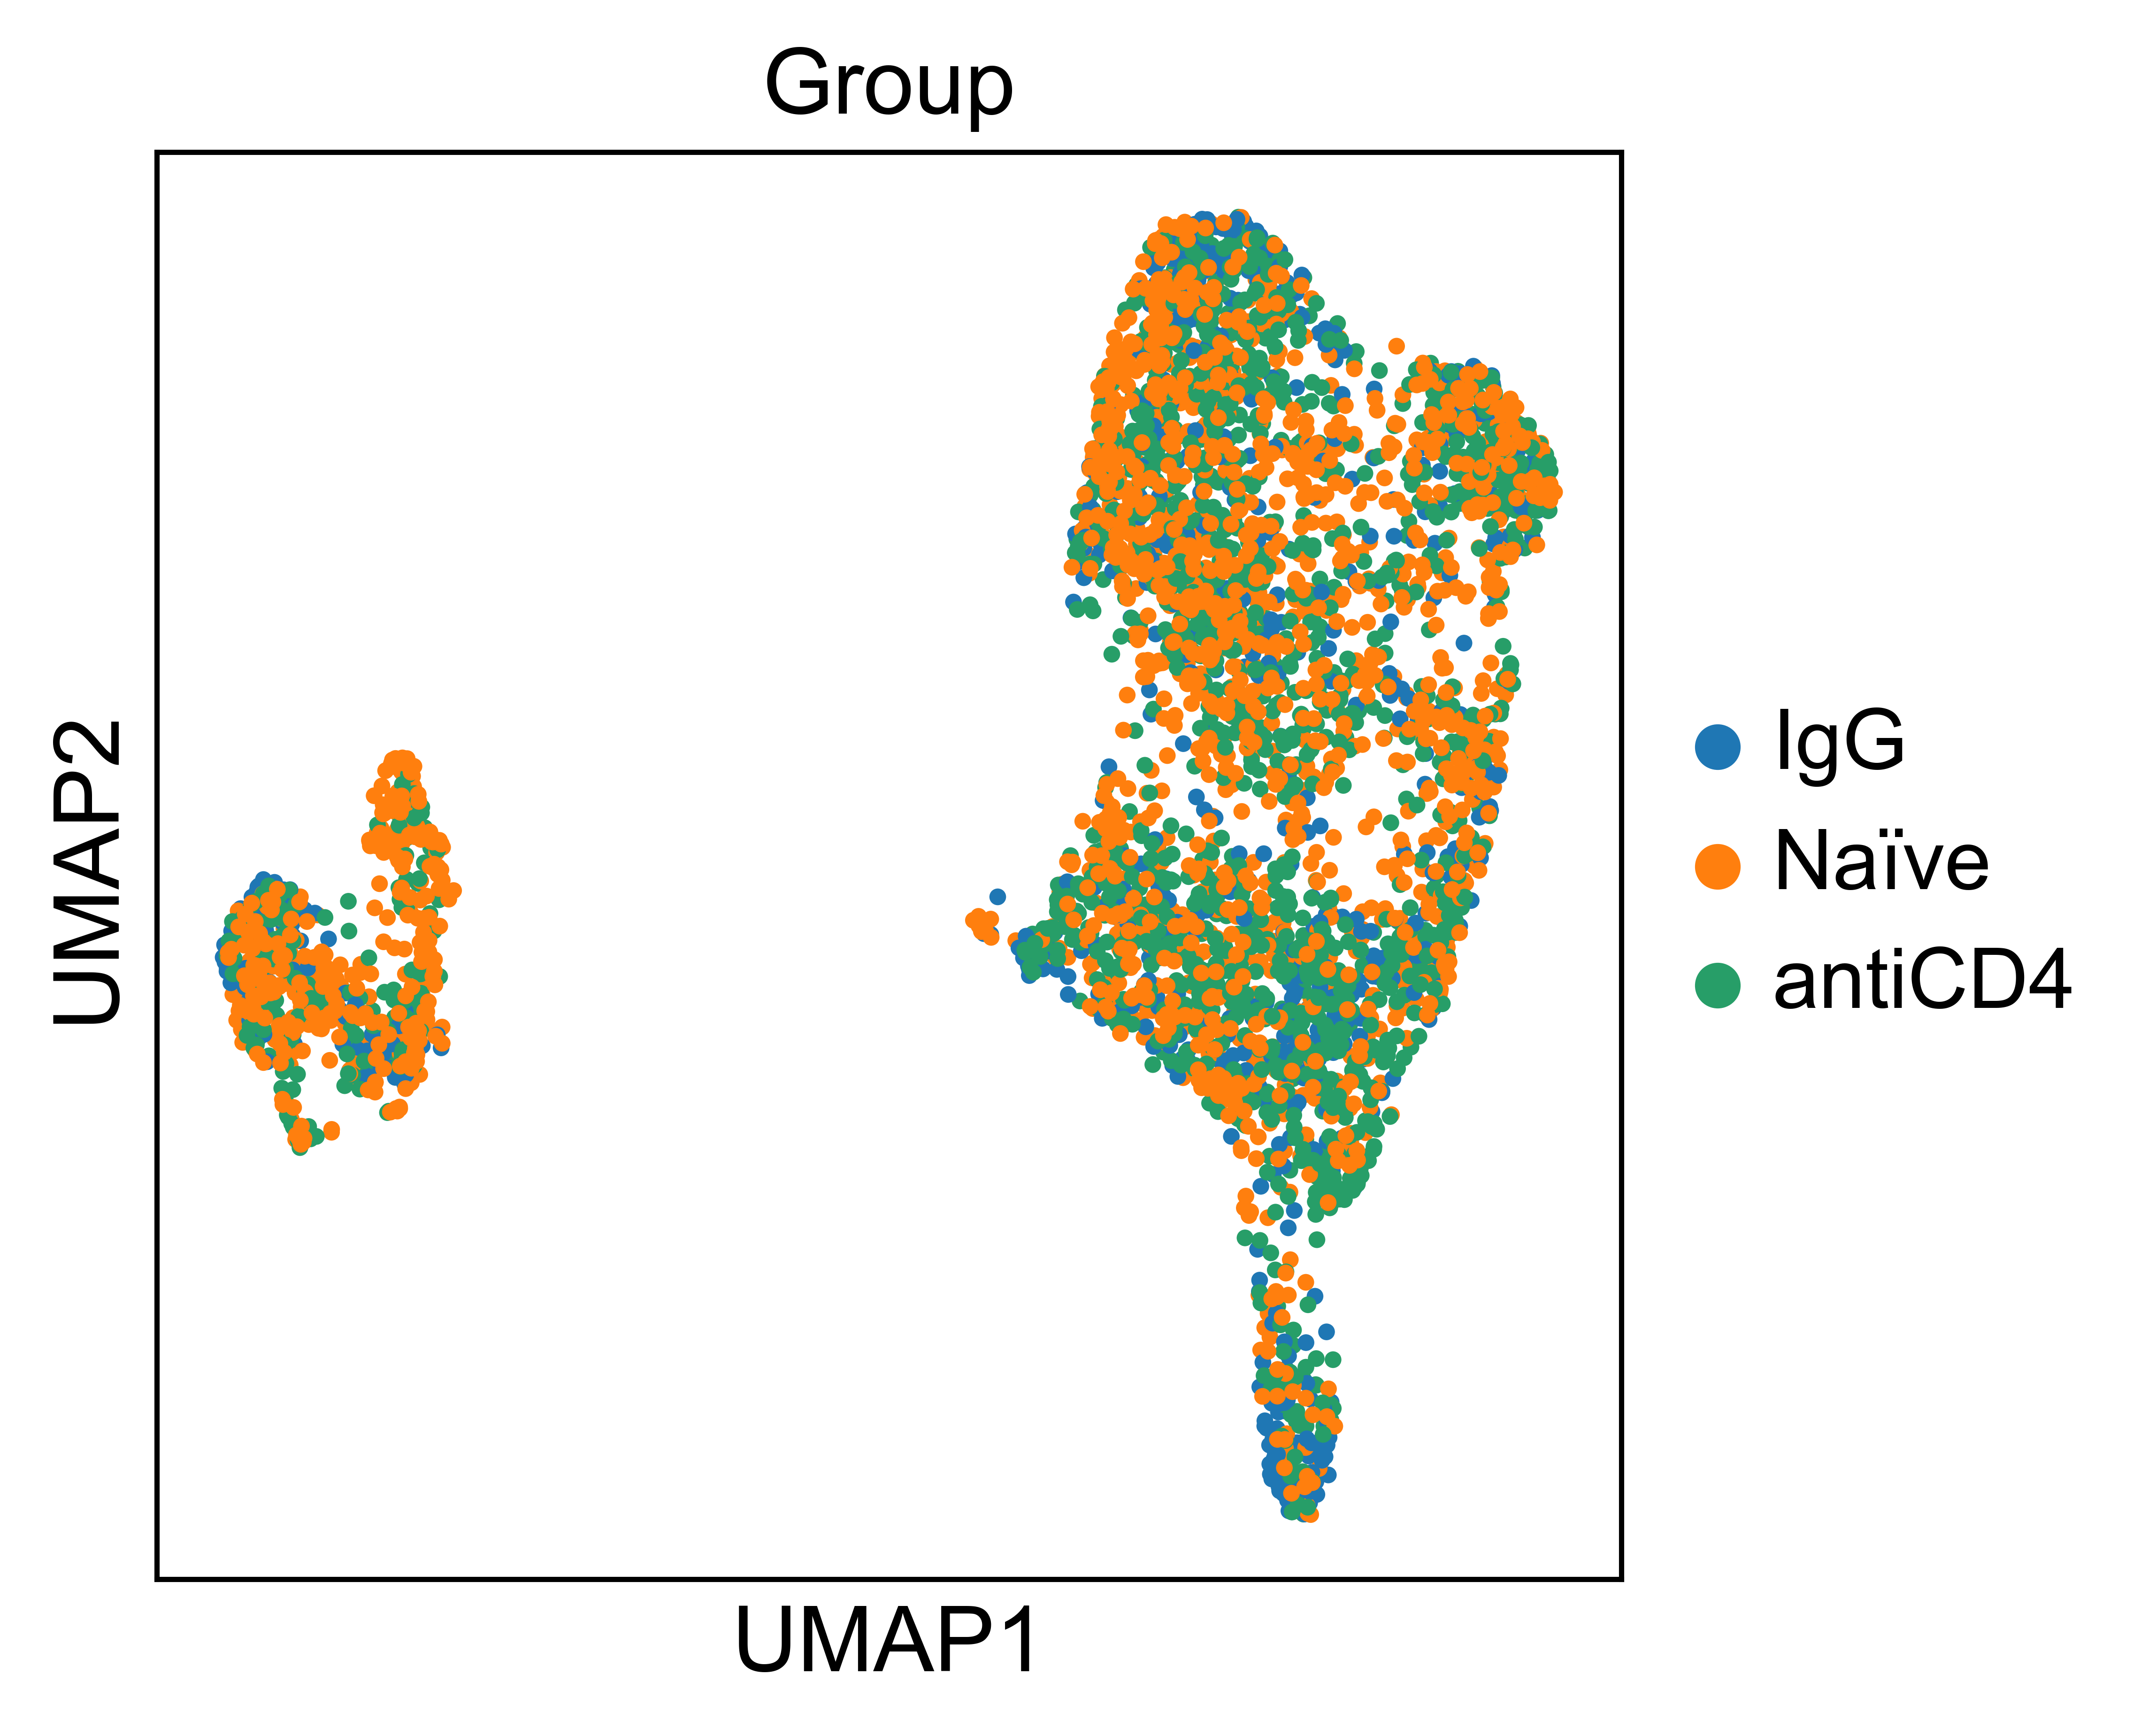

In [8]:
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=12, random_state = 18)
sc.tl.umap(adata, min_dist = 0.1, spread = 2, random_state = 18)
# UMAP with cell cycle genes regressed out 
sc.pl.umap(adata, color = ["Group"])

In [9]:
adata

AnnData object with n_obs × n_vars = 4570 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# 2. Determine optimal cluster resolution for cell subset annotation

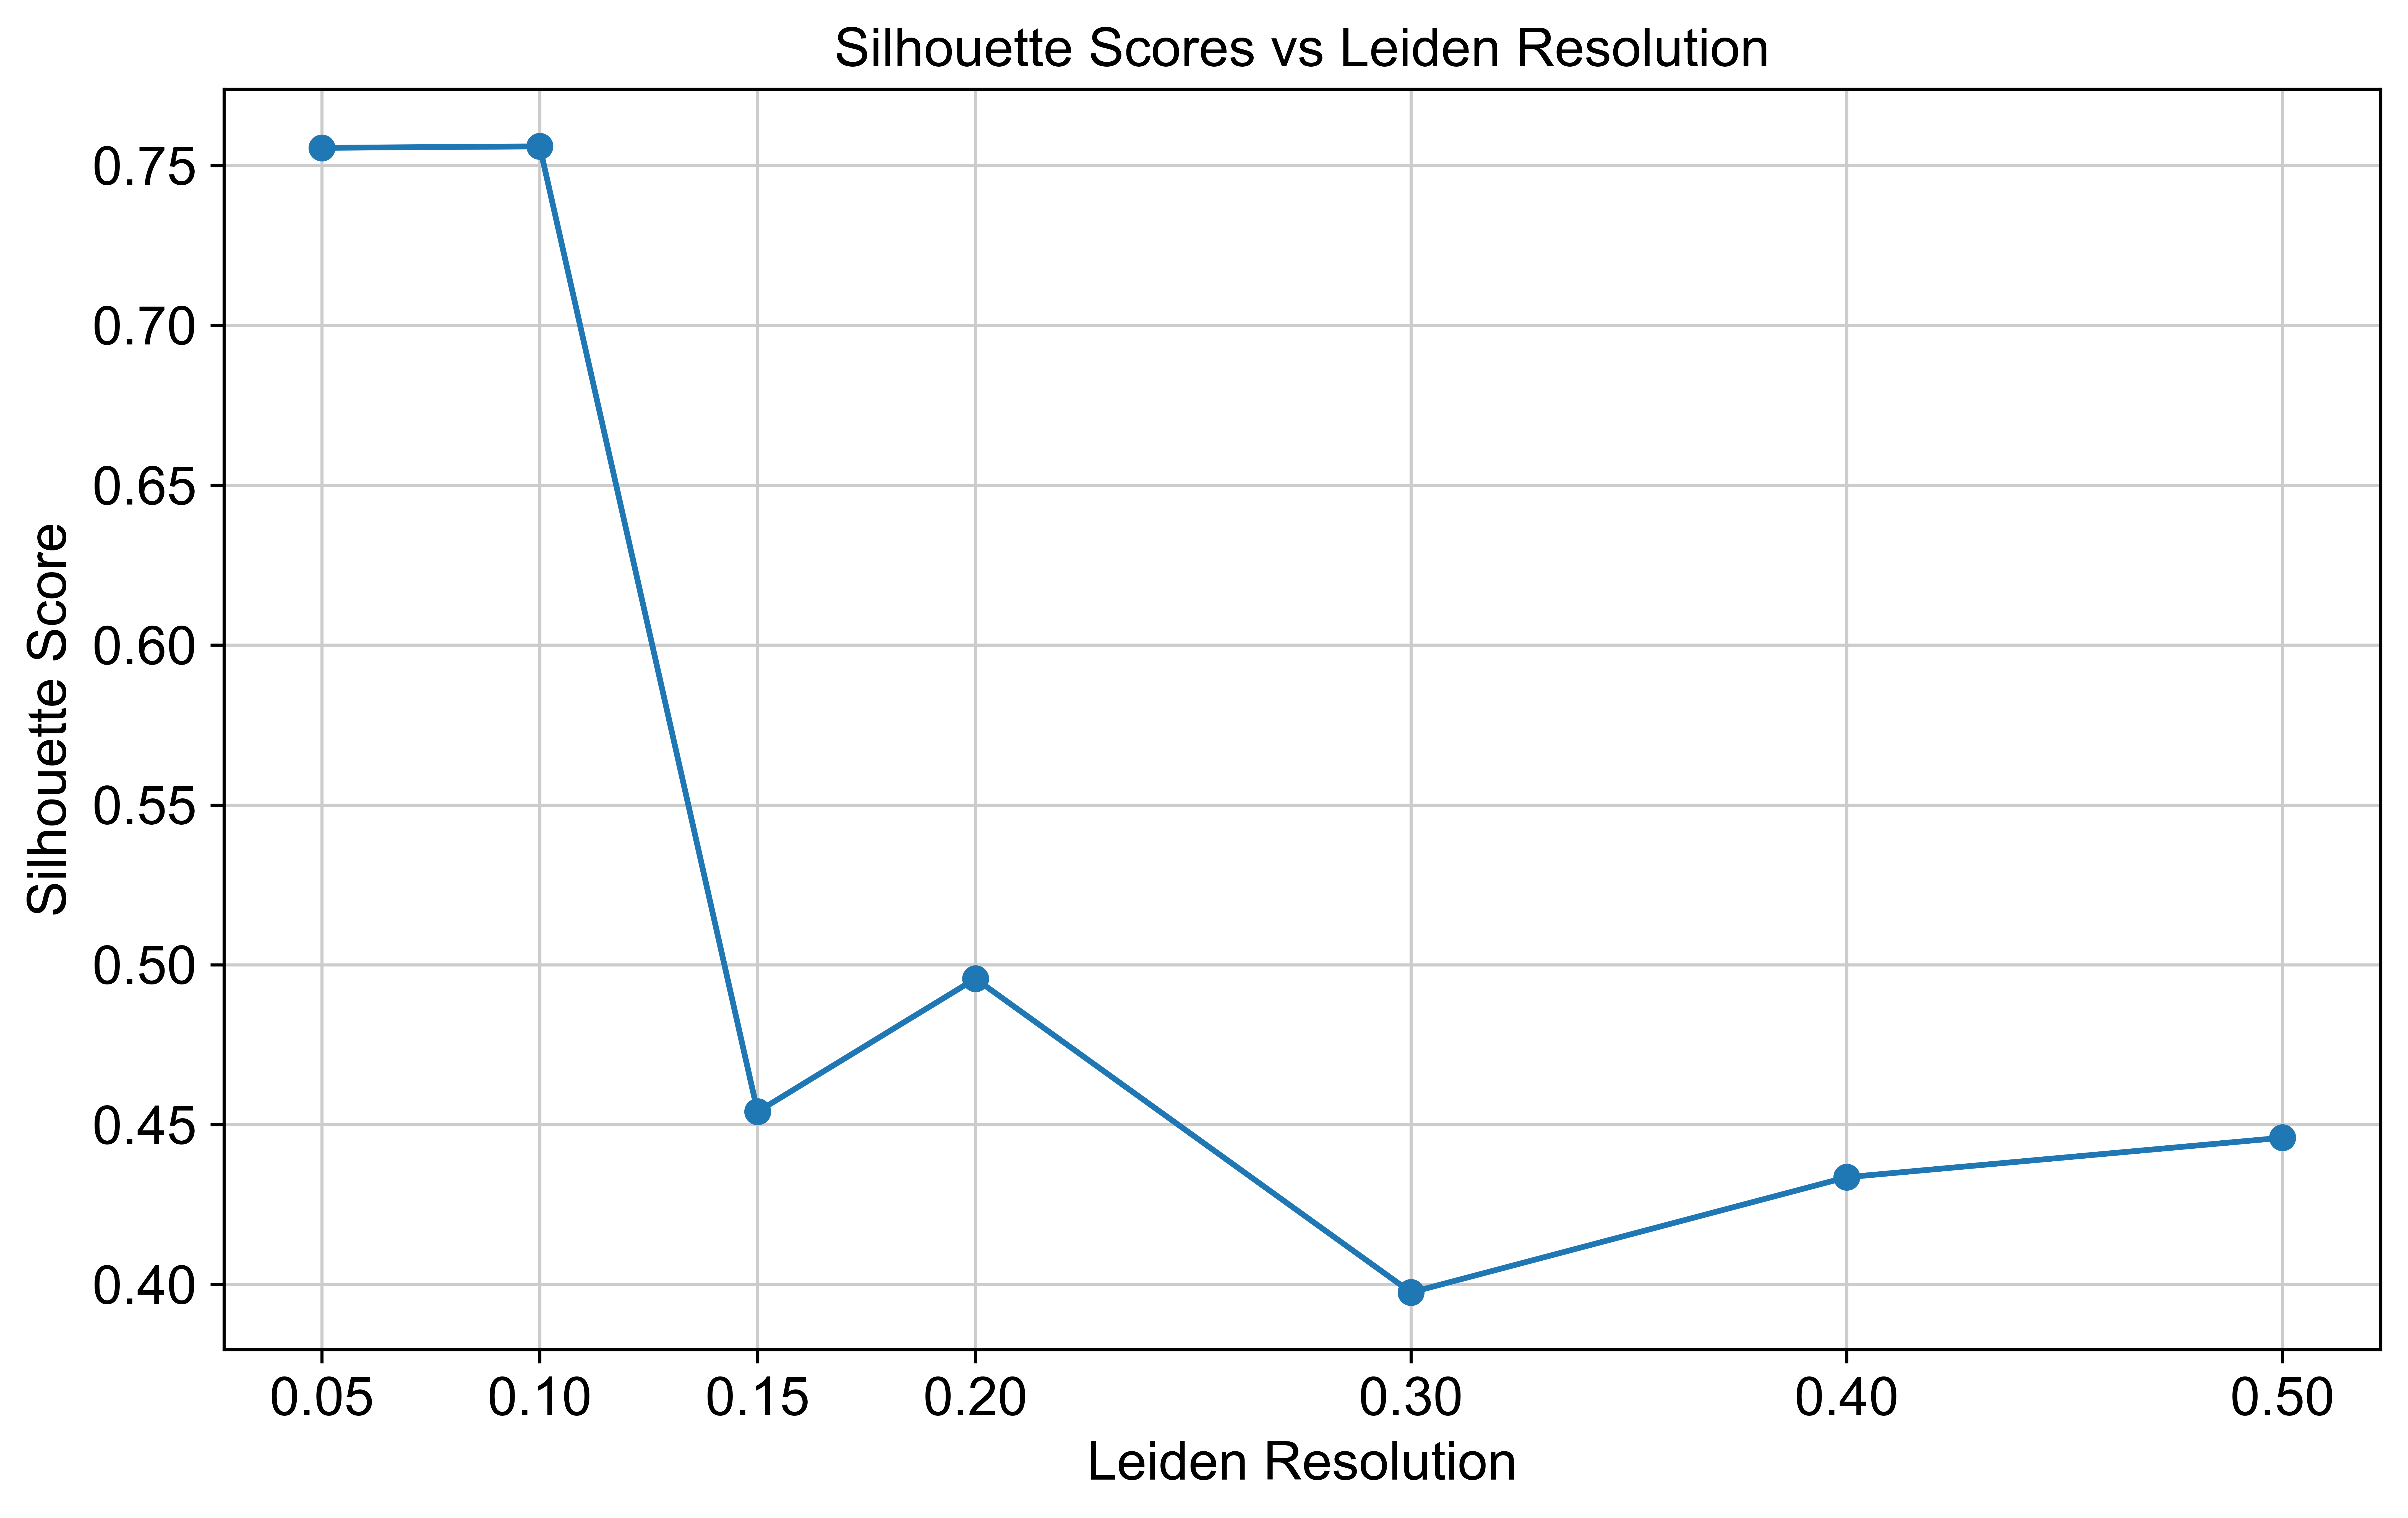

In [15]:
import sklearn
from sklearn.metrics import silhouette_score  
# define resolutions to be tested
resolutions = [0.05,0.1,0.15,0.2,0.3, 0.4, 0.5]

silhouette_scores = []

# calculate silhouette scores for each resolution
for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added=f"leiden_res{res}")
    
    score = sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs[f"leiden_res{res}"], metric='euclidean')
    silhouette_scores.append(score)

plt.figure(figsize=(10,6))
plt.plot(resolutions, silhouette_scores, marker='o')
plt.title('Silhouette Scores vs Leiden Resolution')
plt.xlabel('Leiden Resolution')
plt.ylabel('Silhouette Score')
plt.xticks(resolutions)
plt.grid(True)
plt.show()


resultion 0.1

In [16]:
pd.set_option('display.max_columns', None)
sc.tl.rank_genes_groups(adata, 'leiden_res0.1', method='wilcoxon')
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20))

,0,1
0,MS4A1,JCHAIN
1,LOC102144039,MZB1
2,FCMR,HSP90B1
3,CXCR5,TXNDC5
4,LOC102136862,PDIA4
5,LOC102136468,LMAN1
6,CD74,SSR4
7,CD83,XBP1
8,CD19,HSPA5
9,CD37,FKBP11


In [ ]:
sc.pl.umap(adata, color = ["leiden_res0.1"])

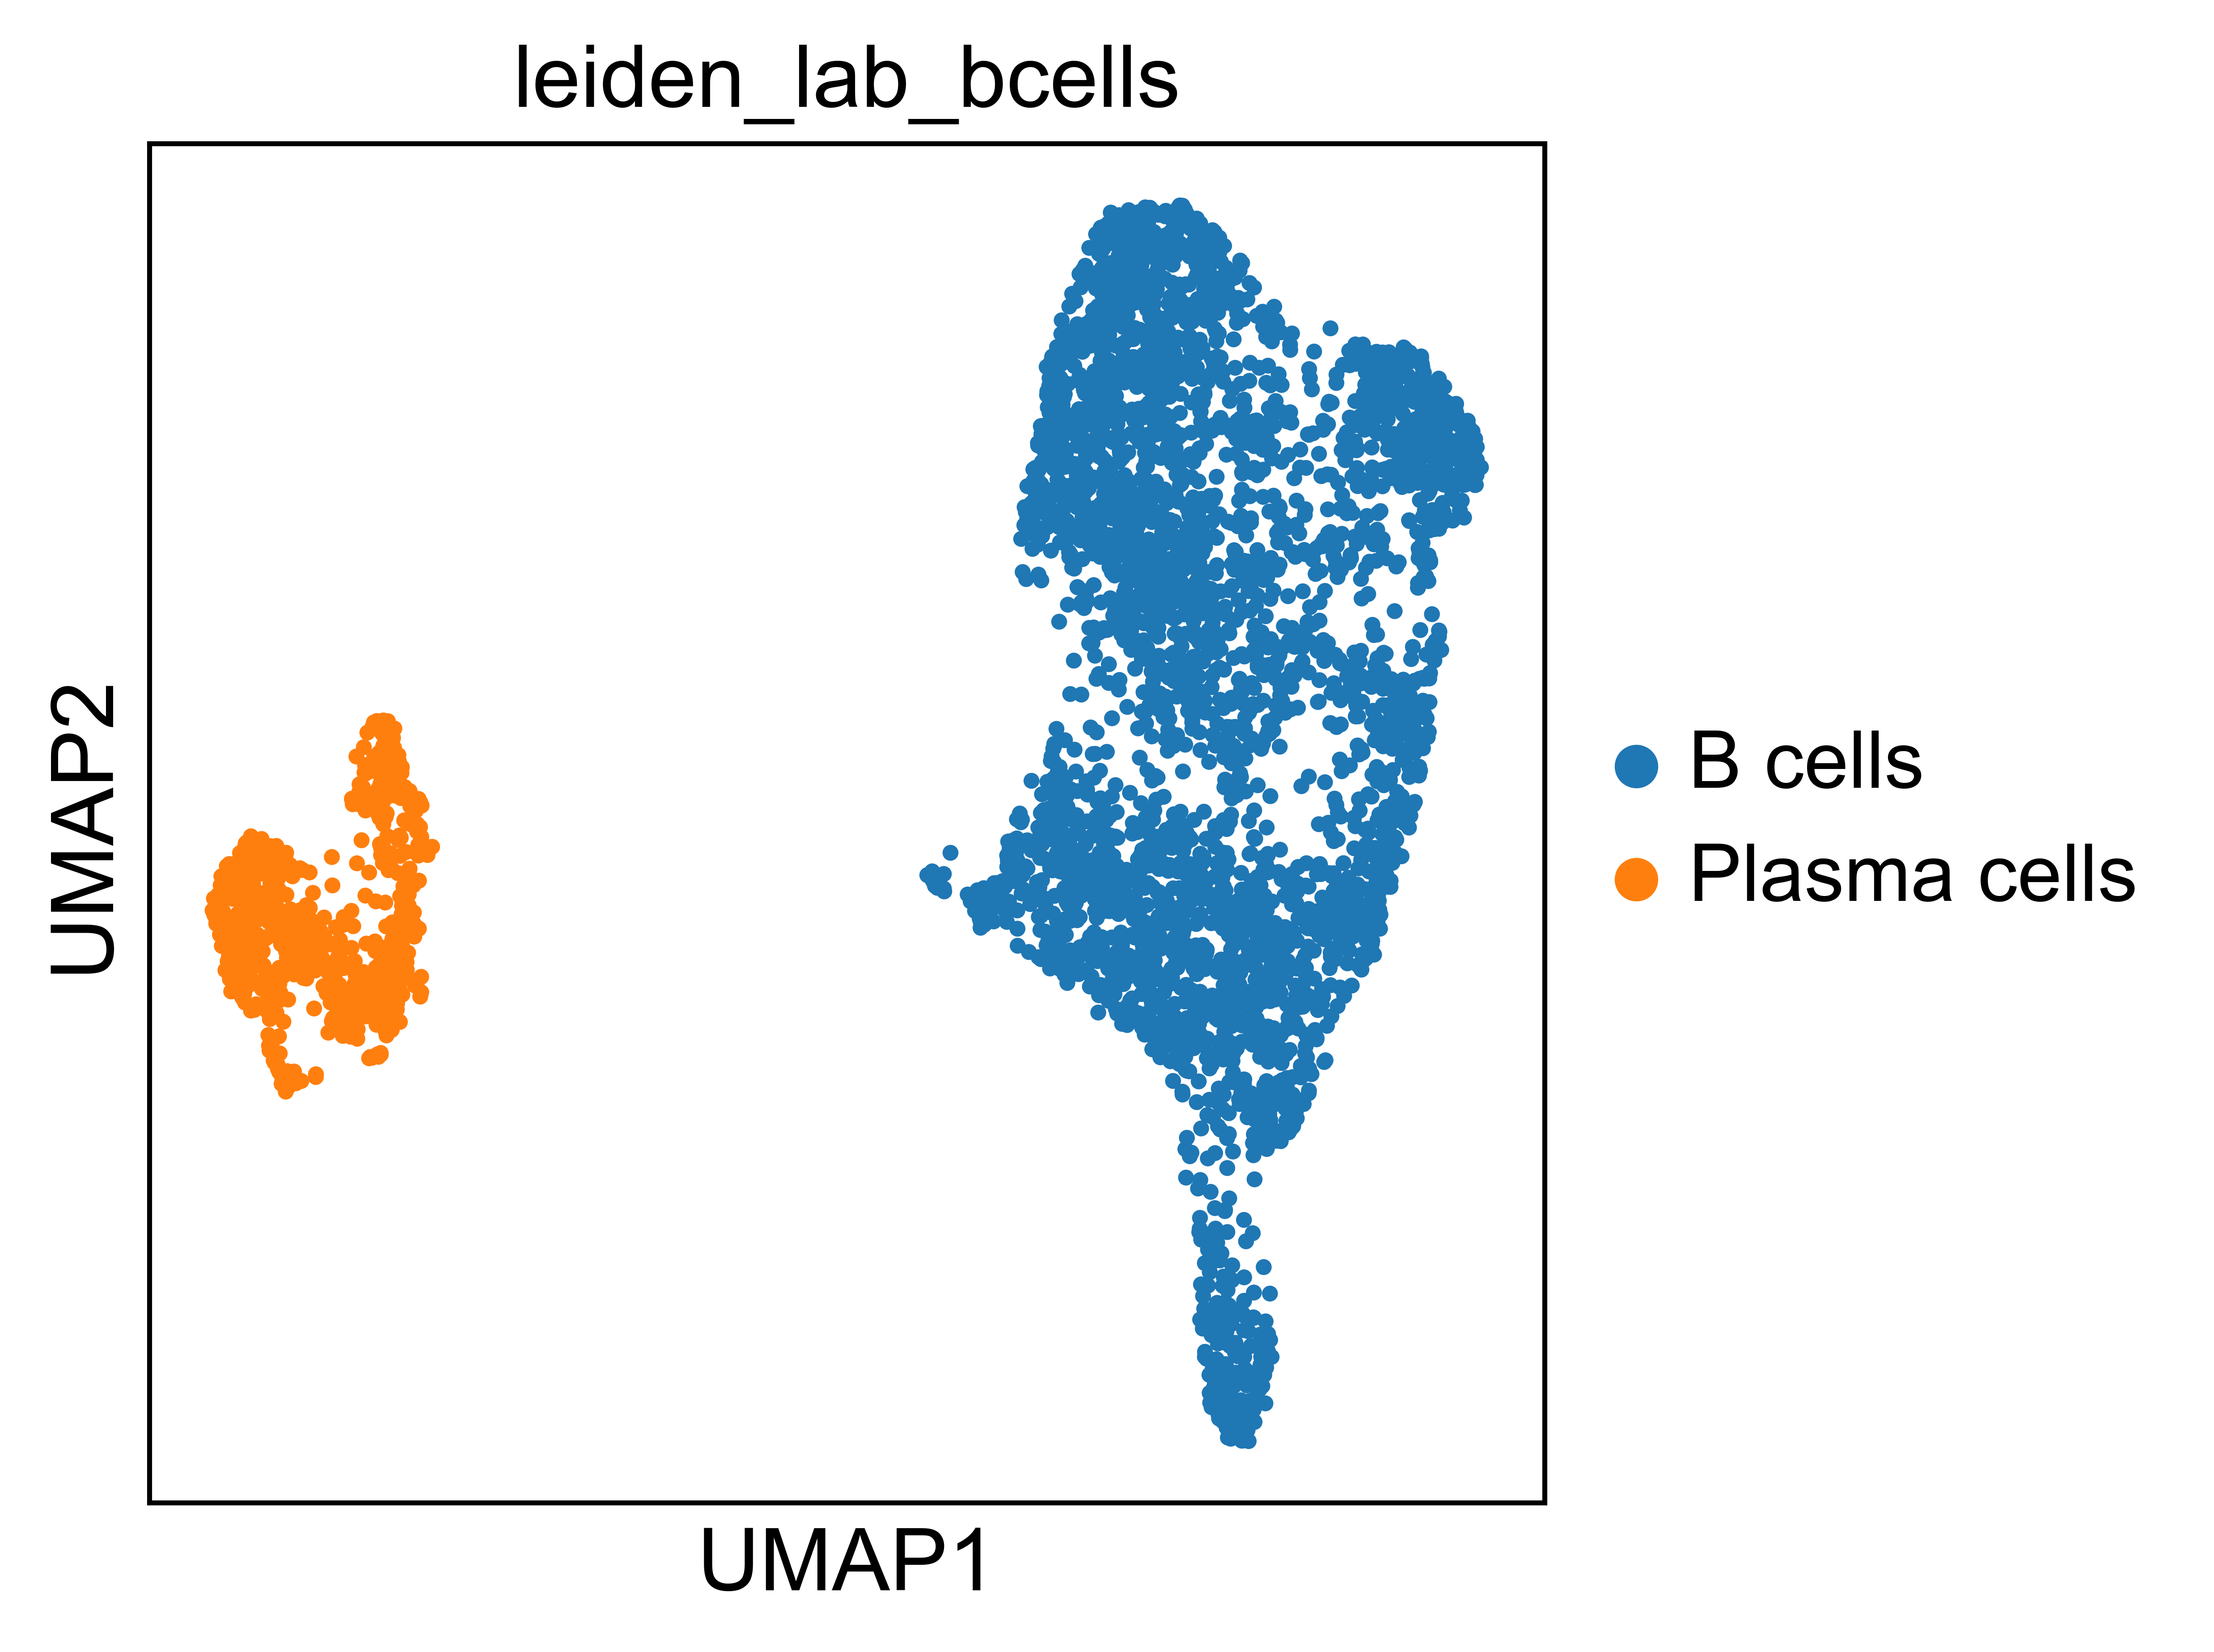

In [18]:
labmap2 = {'0':'B cells',
          '1':'Plasma cells'}
adata.obs['leiden_lab_bcells'] = adata.obs['leiden_res0.1'].replace(labmap2)
sc.pl.umap(adata, color=['leiden_lab_bcells'])


In [19]:
adata_allcells.obs['Subclustering'] = adata_allcells.obs['Subclustering'].astype(str)
adata_allcells.obs.loc[adata.obs.index, 'Subclustering'] = adata.obs['leiden_lab_bcells']
#Save adata_allcells h5ad file w/subclustering idents
adata_allcells.write_h5ad("./Scanpy_H5AD/adata_Final_for_Reinfection_publication.h5ad")
